# Imtiaz Electronics Department Analysis
In this project, we'll examines customer behavior to form effective strategies for enhancing sales and engagement.
## Importing Necessary Libraries 

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
import warnings

# 1. Data Acquisition and Preprocessing:

## 1: Loading Data
Loading Data from JSON file and previewing the dataframe

In [28]:
file=pd.read_json(r"Data\electronics.json")
file.head()  # previewing the loaded data 

,Customer_ID,Age,Gender,Income_Level,Address,Transaction_ID,Purchase_Date,Product_ID,Product_Category,Brand,Purchase_Amount,Average_Spending_Per_Purchase,Purchase_Frequency_Per_Month,Brand_Affinity_Score,Product_Category_Preferences,Month,Year,Season
0,b81ee6c9-2ae4-48a7-b283-220eaa244f43,40,Female,Medium,"43548 Murray Islands Suite 974\nAmyberg, CT 13457",c6a6c712-e36b-406a-bfde-f53bdcf4744f,2022-04-26,d2f767d6-b01a-41a2-87f7-ec1d1186f50e,Clothing,Brand_C,193,59,2,2,Low,01,2010,Winter
1,,25,Male,High,,0b587838-1e4f-4231-b488-42bcd47c052a,2021-08-10,79eadc55-2de1-41cf-b1b6-40118c0bf8ec,Books,Brand_A,318,77,2,1,Low,08,1989,Fall
2,fdf79bcd-5908-4c90-8501-570ffb5b7648,57,Other,Low,"79683 Kevin Hill Apt. 555\nJohnshire, AR 39961",462925b1-a5bf-4996-bda2-59749de64eea,2021-12-09,9ab75a68-4329-4bd9-a259-2233c0f34c93,Electronics,Brand_A,197,100,9,1,Low,,1995,Winter
3,878dccba-893a-48f9-8d34-6ed394fa3c9c,38,Female,Medium,02998 Hall Meadows Suite 809\nNorth Robertvill...,3cfafa02-6b34-4d77-9e05-d223dfab64e8,2022-12-03,d518569b-ff79-494b-b2b6-7e2af39db86a,Clothing,Brand_C,262,97,3,4,Low,09,2012,Fall
4,0af0bd81-73cc-494e-aa5e-75c6d0b6d743,68,Other,Medium,"21411 Timothy Ford Apt. 320\nDavisborough, AR ...",0d8dc27a-0c8f-4a82-b57e-8bf54cee9759,2020-06-08,b6deac9d-2b7e-4a51-8273-a6534910b3bc,Books,Brand_B,429,85,7,2,High,01,2010,Summer


## 2. Data Cleaning:
### Analzing Null and Hidden Values in Dataset

In [29]:
def summarize_data(file):
    file.replace("", np.nan, inplace=True)

    null_info = file.isna().sum()
    null_summary = pd.DataFrame({'NA Values': null_info})

    hidden_info = (file == "Hidden").sum()
    hidden_summary = pd.DataFrame({"Hidden Values ": hidden_info})

    data_summary = pd.concat([null_summary, hidden_summary], axis=1)

    return data_summary

summary_result = summarize_data(file)
summary_result

,NA Values,Hidden Values
Customer_ID,32,12
Age,33,7
Gender,33,15
Income_Level,41,9
Address,32,15
Transaction_ID,39,11
Purchase_Date,35,13
Product_ID,40,9
Product_Category,44,16
Brand,46,12


### Cleaning Hidden Values, Standarizing data formart and checking skewness to apply  appropriate imputaton technique 

In [30]:
# replacing Hidden values column by column with np.nan
for column in file.columns:
    file[column] = file[column].replace("Hidden", np.nan)

# converting formats
file["Age"] = pd.to_numeric(file["Age"], errors = "coerce")
file["Purchase_Amount"] = pd.to_numeric(file["Purchase_Amount"], errors = "coerce")
file["Average_Spending_Per_Purchase"] = pd.to_numeric(file["Average_Spending_Per_Purchase"], errors = "coerce")
file["Purchase_Frequency_Per_Month"] = pd.to_numeric(file["Purchase_Frequency_Per_Month"], errors = "coerce")
file["Brand_Affinity_Score"] = pd.to_numeric(file["Brand_Affinity_Score"], errors = "coerce")
file["Purchase_Date"] = pd.to_datetime(file["Purchase_Date"], errors = "coerce")
file["Year"]=pd.to_numeric(file["Year"], errors = 'coerce')
file["Month"]=pd.to_numeric(file["Month"], errors = 'coerce')

#checking skewness of age for appropriate imputation technique 
age_skew = file["Age"].skew()
Purchase_Amount_skew = file["Purchase_Amount"].skew()
Average_spending_skew = file["Average_Spending_Per_Purchase"].skew()
Purchase_frequency_skew = file["Purchase_Frequency_Per_Month"].skew()
Brand_affinity_skew = file["Brand_Affinity_Score"].skew()

data = {
    'Feature': ['Age', 'Purchase Amount', 'Average Spending Per Purchase', 'Purchase Frequency Per Month', 'Brand Affinity'],
    'Skewness': [age_skew, Purchase_Amount_skew, Average_spending_skew, Purchase_frequency_skew, Brand_affinity_skew]
}
df_skewness = pd.DataFrame(data)
df_skewness

,Feature,Skewness
0,Age,-0.060339
1,Purchase Amount,0.043101
2,Average Spending Per Purchase,0.097847
3,Purchase Frequency Per Month,0.076497
4,Brand Affinity,0.065929


### Cleaning Dataset by applying imputation techniques like mean, median or mode

Plotting relevant columns to analyze and select relevant imputation technique

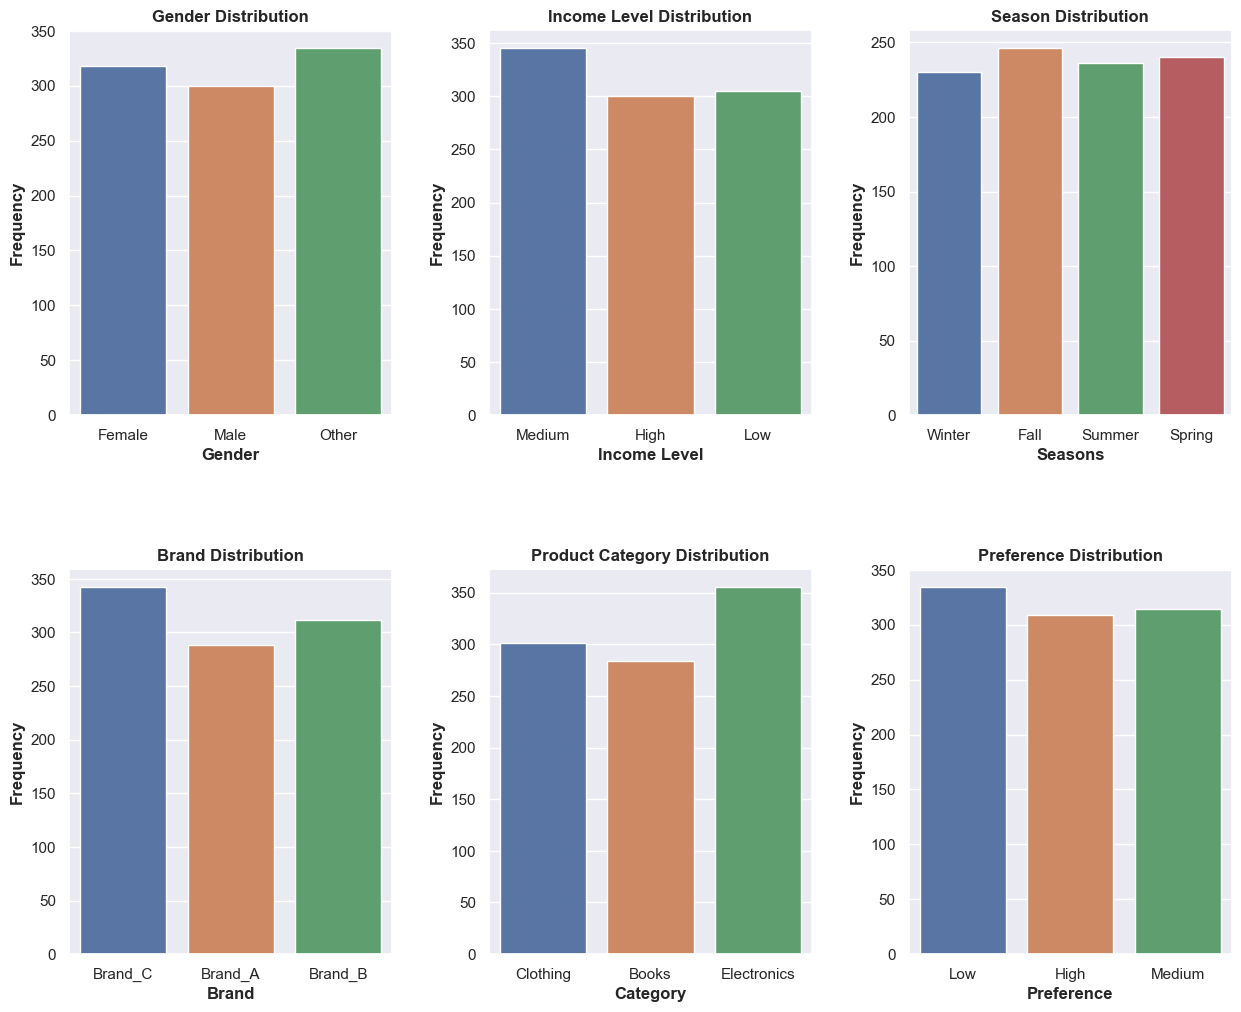

In [31]:
sns.set(rc={'figure.figsize':(15,12)})

# Gender distribution plot
plt.subplot(2, 3, 1) #1st subplot
sns.countplot(x = "Gender", data = file, palette = "deep")
plt.title("Gender Distribution", fontweight = "bold")
plt.xlabel("Gender", fontweight = "bold")
plt.ylabel("Frequency", fontweight = "bold")

# Income Level Plot
plt.subplot(2, 3, 2) #2nd subplot
sns.countplot(x = "Income_Level", data = file, palette = "deep")
plt.title("Income Level Distribution", fontweight = "bold")
plt.xlabel("Income Level", fontweight = "bold")
plt.ylabel("Frequency", fontweight = "bold")

# Season Distribution Plot
plt.subplot(2, 3, 3) #3rd subplot
sns.countplot(x = "Season", data = file, palette = "deep")
plt.title("Season Distribution", fontweight = "bold")
plt.xlabel("Seasons", fontweight = "bold")
plt.ylabel("Frequency", fontweight = "bold")

# Brand Distribution Plot
plt.subplot(2, 3, 4) #4th subplot
sns.countplot(x = "Brand", data = file, palette = "deep")
plt.title("Brand Distribution", fontweight = "bold")
plt.xlabel("Brand", fontweight = "bold")
plt.ylabel("Frequency", fontweight = "bold")

# Product Category Plot
plt.subplot(2, 3, 5) #5th subplot
sns.countplot(x = "Product_Category", data = file, palette = "deep")
plt.title("Product Category Distribution", fontweight = "bold")
plt.xlabel("Category", fontweight = "bold")
plt.ylabel("Frequency", fontweight = "bold")

# Product Category Preference Plot
plt.subplot(2, 3, 6) #6th subplot
sns.countplot(x = "Product_Category_Preferences", data = file, palette = "deep")
plt.title("Preference Distribution", fontweight = "bold")
plt.xlabel("Preference", fontweight = "bold")
plt.ylabel("Frequency", fontweight = "bold")

# plotting subplot
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

In [32]:
# Age is left skewed but is not highly skewed therefore we can apply mean
file["Age"].fillna(file["Age"].mean(), inplace = True)

# Purchase Amount is right skewed but is not highly skewed therefore we can apply mean
file["Purchase_Amount"].fillna(file["Purchase_Amount"].mean(), inplace = True)

# Average Spending Per Purchase is right skewed but is not highly skewed therefore we can apply mean
file["Average_Spending_Per_Purchase"].fillna(file["Average_Spending_Per_Purchase"].mean(), inplace = True)

# Average Spending Per Purchase is right skewed but is not highly skewed therefore we can apply mean
file["Average_Spending_Per_Purchase"].fillna(file["Average_Spending_Per_Purchase"].mean(), inplace = True)

# Purchase Frequency Per Month is right skewed but is not highly skewed therefore we can apply mean
file["Purchase_Frequency_Per_Month"].fillna(file["Purchase_Frequency_Per_Month"].mean(), inplace = True)

# Brand Affinity Score is symmetrical therefore we can apply mean
file["Brand_Affinity_Score"].fillna(file["Brand_Affinity_Score"].mean(), inplace = True)

# Applying mode to fill missing Gender Values
file["Gender"].fillna(file["Gender"].mode()[0], inplace = True)

file["Product_Category_Preferences"].fillna(file["Product_Category_Preferences"].mode()[0],inplace=True)

# Applying mode to fill missing Income Levels
file["Income_Level"].fillna(file["Income_Level"].mode()[0], inplace = True)

# Applying mode to fill missig Season Values 
file["Season"].fillna(file["Season"].mode()[0], inplace = True)

# Applying mode to fill missig Brand Values 
file["Brand"].fillna(file["Brand"].mode()[0], inplace = True)

### Dropping rows having appropriate missing values or replacing them with Unknown 

In [33]:
# Dropping Customer id with na values
file.dropna(subset=["Customer_ID"], inplace = True)

# Dropping Transaction id with na values
file.dropna(subset=["Transaction_ID"], inplace = True)

# Filling Missing Address with unknwon 
file["Address"].fillna("Unknown", inplace = True)

# Filling missig Product ID Values 
file["Product_ID"].fillna("Unknown", inplace = True)

# Filling missig Product Category Values 
file["Product_Category"].fillna("Unknown", inplace = True)

### Cleaning Missing Dates, Months and Years
First sorting by the date to be filled and then using forward fill (ffill) to replace missing values

In [34]:
# Fixing Purchase Date
file.sort_values(by = "Purchase_Date", inplace = True)   # sorting by purchase date
file["Purchase_Date"].fillna(method = "ffill", inplace = True)

# Fixing year and month 
file.sort_values(by=["Year", "Month"], inplace = True)  # sorting by year and month
file["Year"].fillna(method = "ffill", inplace = True)
file["Month"].fillna(method = "ffill", inplace = True)

### Cheking Cleaned Dataset
Checking for Hidden or Null values in dataset 

In [35]:
summary_result = summarize_data(file)
summary_result

,NA Values,Hidden Values
Customer_ID,0,0
Age,0,0
Gender,0,0
Income_Level,0,0
Address,0,0
Transaction_ID,0,0
Purchase_Date,0,0
Product_ID,0,0
Product_Category,0,0
Brand,0,0


In [36]:
file.head()

,Customer_ID,Age,Gender,Income_Level,Address,Transaction_ID,Purchase_Date,Product_ID,Product_Category,Brand,Purchase_Amount,Average_Spending_Per_Purchase,Purchase_Frequency_Per_Month,Brand_Affinity_Score,Product_Category_Preferences,Month,Year,Season
968,fcfb43b9-0480-4917-9da8-6e17c884d83f,43.0,Female,Medium,"99119 Richard Courts\nLake Mario, IN 71899",673296a4-b23d-4a36-9e90-e41b1164f025,2020-10-22,e56c5b9c-cd45-42de-a92c-2cc451958e6a,Books,Brand_A,162.0,16.0,8.0,5.369542,Medium,1.0,1970.0,Winter
688,a455f76c-cf6f-4cd6-9837-95250f45cd01,61.0,Other,Low,"2359 Mendez Point\nBriantown, AR 71911",2236855c-d6f6-4d63-9b76-3a07059933df,2021-11-26,42e75e81-4e7f-465a-96ff-49de5ff1dd5b,Clothing,Brand_A,169.0,64.0,1.0,7.000000,Low,2.0,1970.0,Fall
210,4697137e-18c0-4b48-9d23-5a967e774af4,65.0,Male,High,Unknown,30ef54cd-6a57-4712-85e3-321035d63c48,2022-05-29,1eacb3e7-d49a-4b6d-9c4a-978c58919117,Clothing,Brand_A,162.0,89.0,5.0,6.000000,Medium,2.0,1970.0,Summer
97,7c76c5e0-918a-4106-a814-631d64872c3b,68.0,Male,High,"1271 Marilyn Orchard Suite 839\nPort Tinaport,...",64e78933-0a6f-4ad7-aec8-be304b411437,2020-05-21,a5b9a371-7240-4720-a2f8-a3662983e713,Clothing,Brand_B,480.0,88.0,5.0,6.000000,Medium,3.0,1970.0,Winter
391,87977cfd-8c43-47db-9533-4ce6d9e0b4a7,25.0,Other,Low,"35107 Terry Tunnel Apt. 014\nCatherineborough,...",e82f7a98-465f-4ab2-b5dd-4d97c6809f43,2023-01-13,3e510b79-6a33-4c10-88c4-32c4d306abfd,Clothing,Brand_C,444.0,58.0,7.0,4.000000,Medium,3.0,1970.0,Summer


## 3. Data Transformation:
New feature columns have already been integraded to the dataset by default,
Performing transformation for clustering analysis

In [37]:
# seprating numeric and non numeric columns
label_encoder = LabelEncoder()
numeric_columns = file.select_dtypes(include=["float64", "int64"]).columns
non_numeric_columns = file.select_dtypes(exclude=["float64", "int64"]).columns

# For Kmeans
scaler = StandardScaler()
file_standardized = file.copy()
file_standardized[numeric_columns] = scaler.fit_transform(file[numeric_columns])

# For Dbscan 
scaler = MinMaxScaler()
file_normalized = file.copy()
file_normalized[numeric_columns] = scaler.fit_transform(file[numeric_columns])

# Data Encoding
# For Kmeans
file_standardized['Gender_Encoded'] = label_encoder.fit_transform(file['Gender'])
file_standardized['Product_Category_Encoded'] = label_encoder.fit_transform(file['Product_Category'])
file_standardized['Brand_Encoded'] = label_encoder.fit_transform(file['Brand'])
file_standardized['Product_Category_Preferences_Encoded'] = label_encoder.fit_transform(file['Product_Category_Preferences'])
file_standardized['Season'] = label_encoder.fit_transform(file['Season'])

# For Dbscan
file_normalized['Gender_Encoded'] = label_encoder.fit_transform(file['Gender'])
file_normalized['Product_Category_Encoded'] = label_encoder.fit_transform(file['Product_Category'])
file_normalized['Brand_Encoded'] = label_encoder.fit_transform(file['Brand'])
file_normalized['Product_Category_Preferences_Encoded'] = label_encoder.fit_transform(file['Product_Category_Preferences'])
file_normalized['Season'] = label_encoder.fit_transform(file['Season'])

# Performing Cluster Analysis on Average Spending Per Purchase w.r.t Age
average_purchase_per_age_standard = file_standardized[["Age", "Average_Spending_Per_Purchase"]]
average_purchase_per_age_normalized = file_normalized[["Age", "Average_Spending_Per_Purchase"]]

# Performing Cluster Analysis on purchase frequence and brand affinity 
purchase_freq_affinity_standard = file_standardized[["Brand_Affinity_Score", "Purchase_Frequency_Per_Month"]]
purchase_freq_affinity_normalized = file_normalized[["Brand_Affinity_Score", "Purchase_Frequency_Per_Month"]]

# purchase amount and age
purchase_amount_age_normalized = file[["Age", "Purchase_Amount"]]



cluster_frames_standard = [average_purchase_per_age_standard, purchase_freq_affinity_standard]
cluster_frames_normal = [average_purchase_per_age_normalized, purchase_freq_affinity_normalized]

# 2. Exploratory Data Analysis(EDA):

## 1. Univariate Analysis:

### A. Key feature distribution


### **Age:**

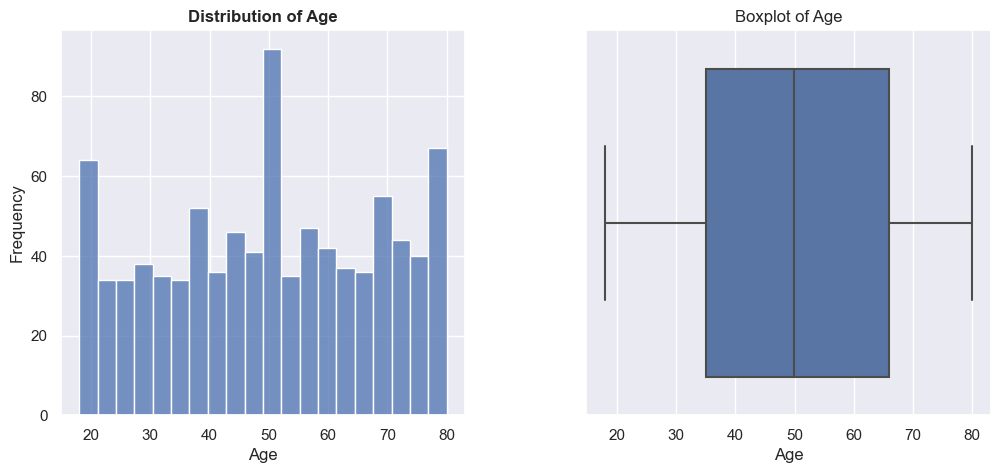

In [38]:
sns.set(rc={'figure.figsize':(12,5)})

plt.subplot(1,2,1)
sns.histplot(file['Age'], bins=20)
plt.title('Distribution of Age', fontweight="bold")
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=file['Age'])
plt.title('Boxplot of Age')
plt.xlabel('Age')

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

### **Purchase Amount:**

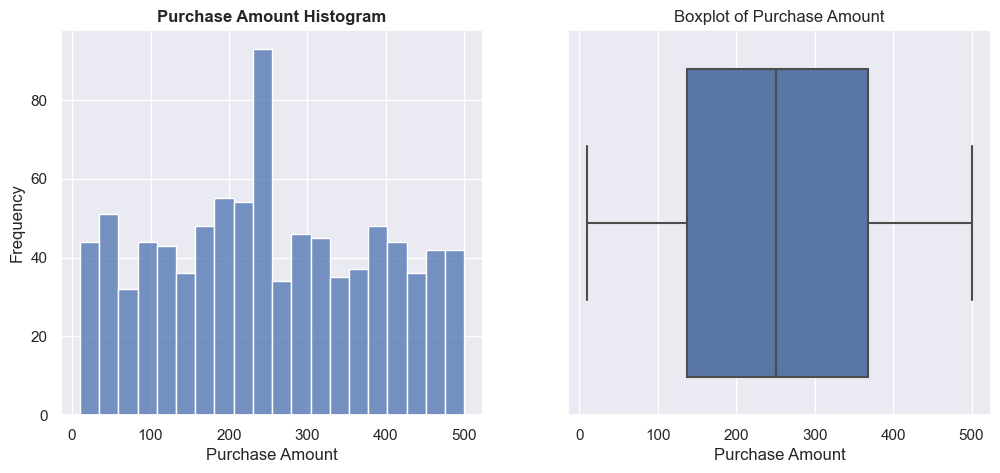

In [39]:
plt.subplot(1,2,1)
sns.histplot(file['Purchase_Amount'], bins=20)
plt.title('Purchase Amount Histogram', fontweight="bold")
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=file['Purchase_Amount'])
plt.title('Boxplot of Purchase Amount')
plt.xlabel('Purchase Amount')
plt.show()

### **Purchase Frequency:**

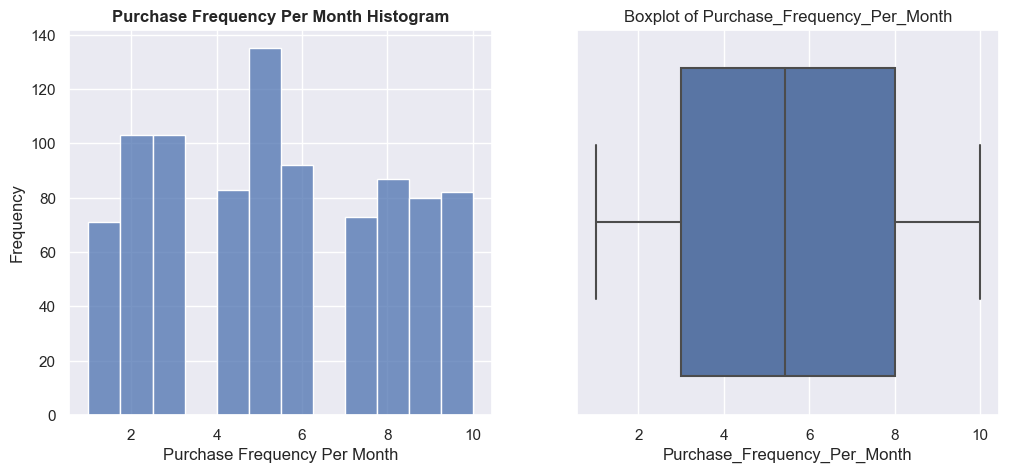

In [40]:
plt.subplot(1,2,1)
sns.histplot(file['Purchase_Frequency_Per_Month'], bins=12)
plt.title('Purchase Frequency Per Month Histogram', fontweight="bold")
plt.xlabel('Purchase Frequency Per Month')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=file['Purchase_Frequency_Per_Month'])
plt.title('Boxplot of Purchase_Frequency_Per_Month')
plt.xlabel('Purchase_Frequency_Per_Month')
plt.show()

### **Brand Affinity:**

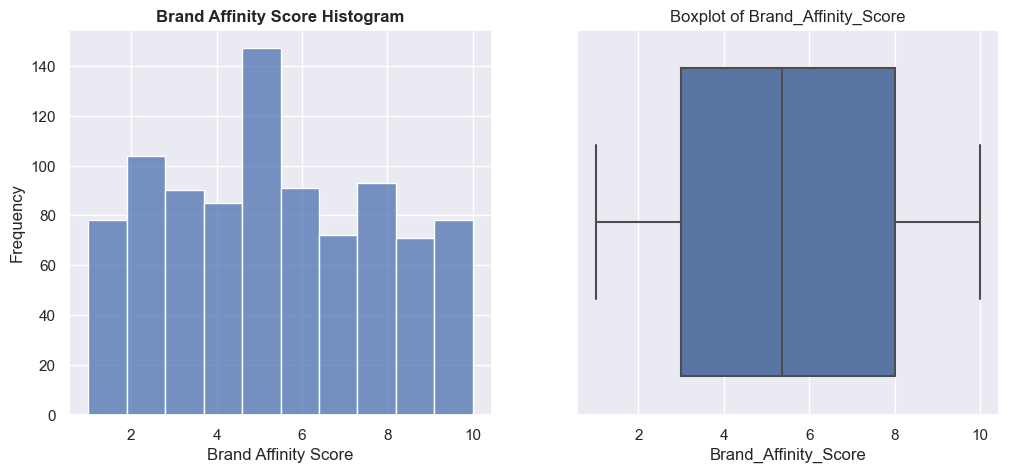

In [41]:
plt.subplot(1,2,1)
sns.histplot(file['Brand_Affinity_Score'], bins=10)
plt.title('Brand Affinity Score Histogram', fontweight="bold")
plt.xlabel('Brand Affinity Score')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=file['Brand_Affinity_Score'])
plt.title('Boxplot of Brand_Affinity_Score')
plt.xlabel('Brand_Affinity_Score')
plt.show()

### **Categorical Data Count:**

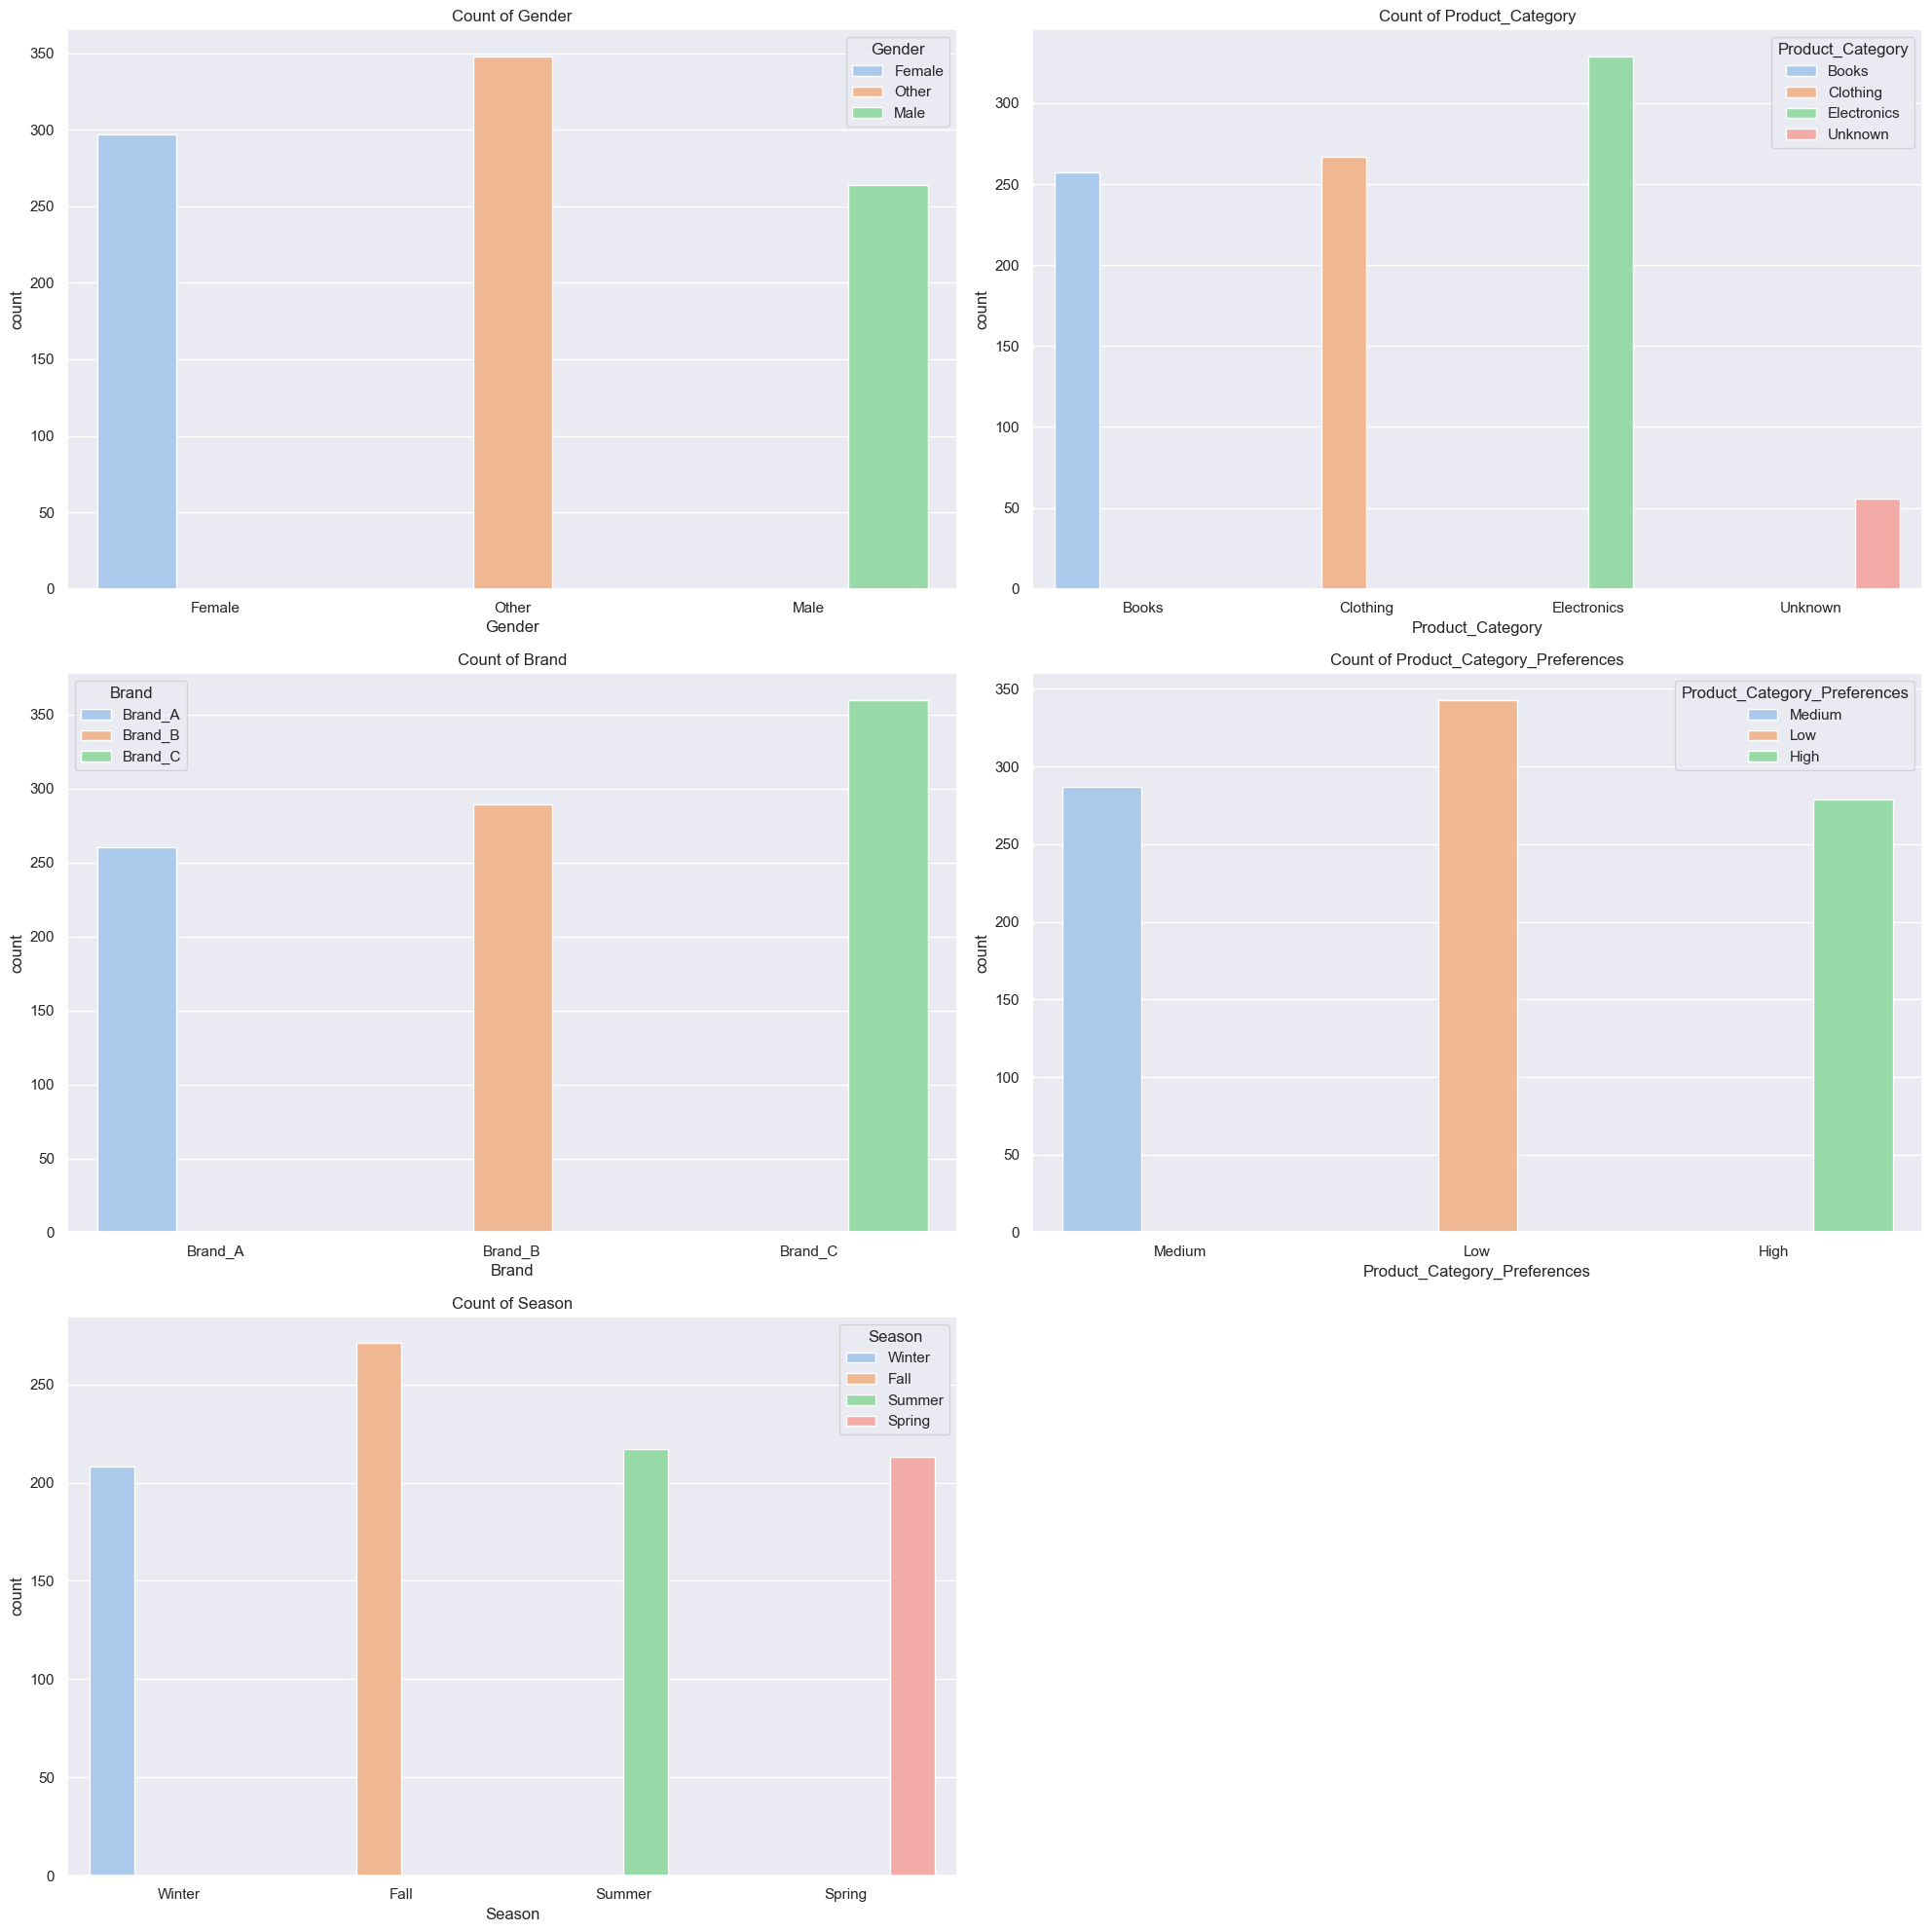

In [42]:
cat_var = ['Gender', 'Product_Category', 'Brand', 'Product_Category_Preferences', 'Season']

plt.figure(figsize=(20, 20))

# Looping through categorical variables and creating subplots
for i, var in enumerate(cat_var, start=1):
    plt.subplot(3, 2, i)
    sns.countplot(data=file, x=var, hue=var, palette='pastel')
    plt.title(f'Count of {var}')

plt.tight_layout()
plt.show()

### **Descriptive Statistics:**

In [43]:
descriptive_stats = file[['Age', 'Purchase_Amount', 'Purchase_Frequency_Per_Month', 'Average_Spending_Per_Purchase']].describe()

print(descriptive_stats)

              Age  Purchase_Amount  Purchase_Frequency_Per_Month  \
count  909.000000       909.000000                    909.000000   
mean    49.922981       250.786264                      5.407220   
std     18.063674       136.702418                      2.759522   
min     18.000000        10.000000                      1.000000   
25%     35.000000       137.000000                      3.000000   
50%     49.885417       250.629863                      5.437037   
75%     66.000000       368.000000                      8.000000   
max     80.000000       500.000000                     10.000000   

       Average_Spending_Per_Purchase  
count                     909.000000  
mean                       51.704854  
std                        26.434911  
min                         5.000000  
25%                        30.000000  
50%                        51.603125  
75%                        73.000000  
max                       100.000000  


### B. Potential Skewness and Outliers:

Based upon following table data is not highly skewed

In [44]:
df_skewness

,Feature,Skewness
0,Age,-0.060339
1,Purchase Amount,0.043101
2,Average Spending Per Purchase,0.097847
3,Purchase Frequency Per Month,0.076497
4,Brand Affinity,0.065929


## 2. Bivariate Analysis:

### A. Relationship between different Features 

### **Purchase Amount vs Income Level:**

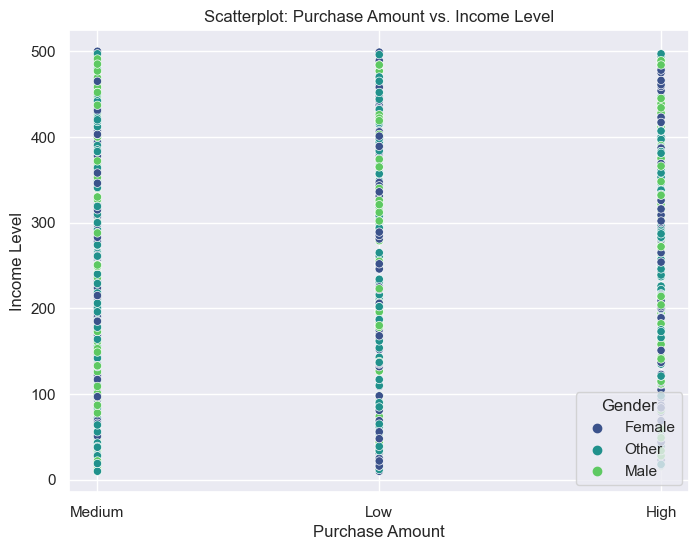

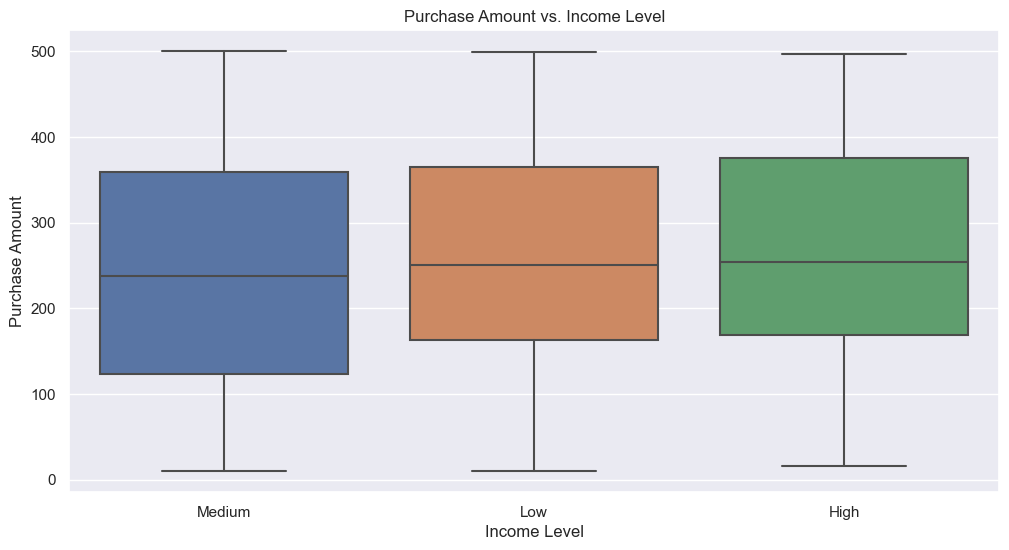

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income_Level', y='Purchase_Amount', data=file, hue='Gender', palette='viridis')
plt.title('Scatterplot: Purchase Amount vs. Income Level')
plt.ylabel('Income Level')
plt.xlabel('Purchase Amount')
plt.legend(title='Gender')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Income_Level', y='Purchase_Amount', data=file)
plt.title('Purchase Amount vs. Income Level')
plt.xlabel('Income Level')
plt.ylabel('Purchase Amount')
plt.show()

### **Brand Affinity vs Product Category:**

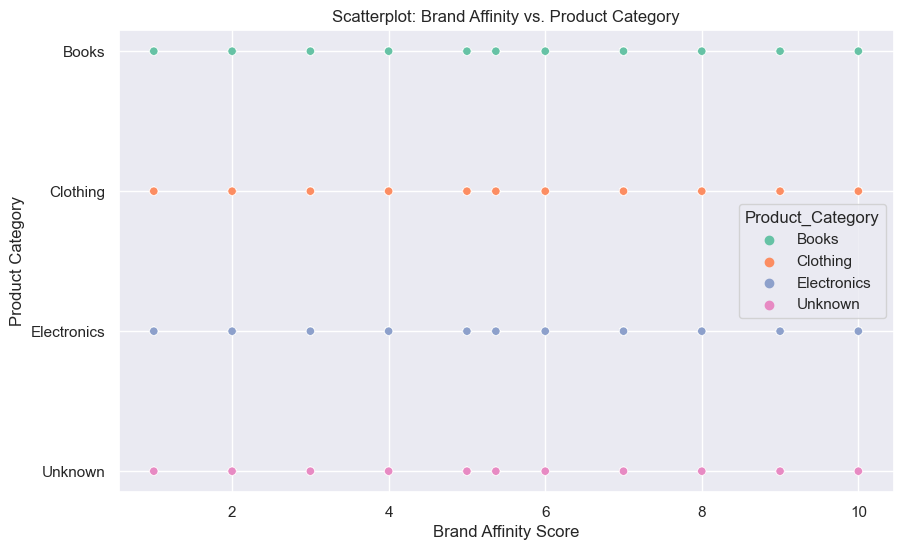

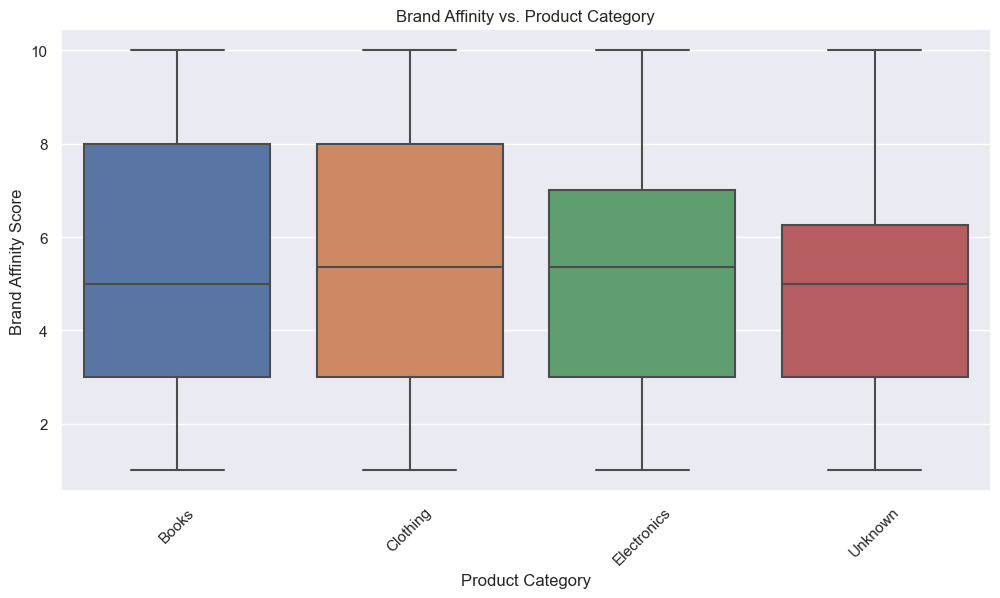

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Brand_Affinity_Score', y='Product_Category', data=file, hue='Product_Category', palette='Set2')
plt.title('Scatterplot: Brand Affinity vs. Product Category')
plt.xlabel('Brand Affinity Score')
plt.ylabel('Product Category')
plt.show()
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product_Category', y='Brand_Affinity_Score', data=file)
plt.title('Brand Affinity vs. Product Category')
plt.xticks(rotation=45)
plt.xlabel('Product Category')
plt.ylabel('Brand Affinity Score')
plt.show()

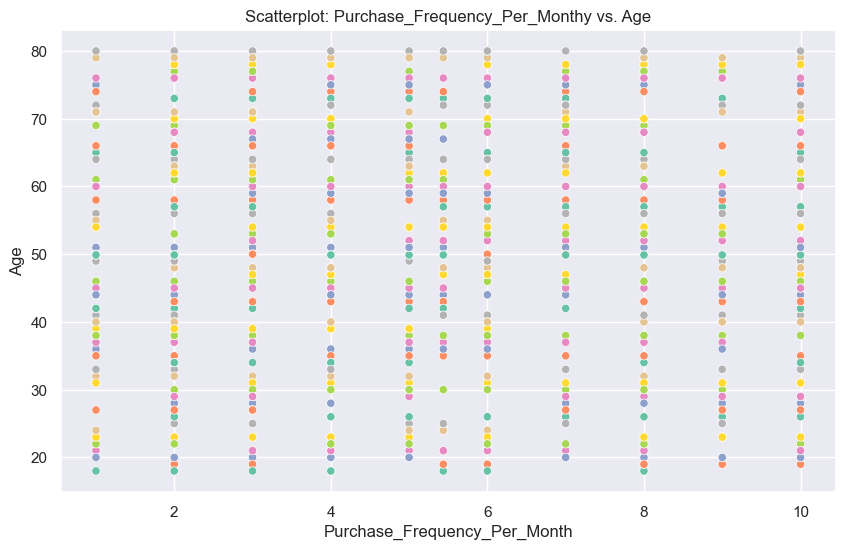

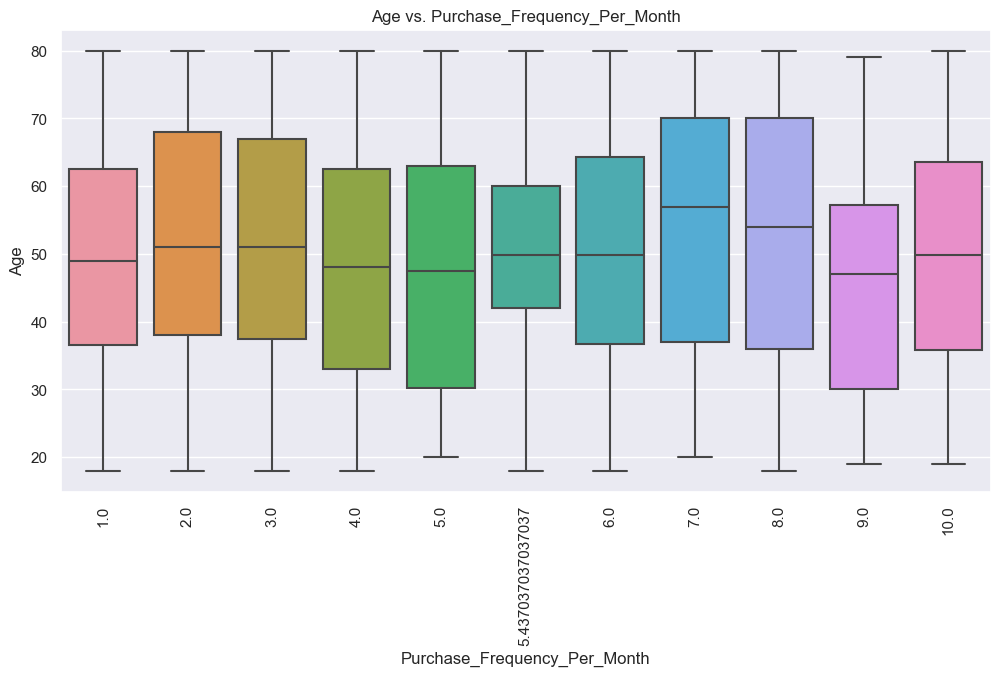

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y='Age', x='Purchase_Frequency_Per_Month', data=file, hue='Age', palette='Set2',legend=False)
plt.title('Scatterplot: Purchase_Frequency_Per_Monthy vs. Age')
plt.ylabel('Age')
plt.xlabel('Purchase_Frequency_Per_Month')
plt.show()
plt.figure(figsize=(12, 6))
sns.boxplot(y='Age', x='Purchase_Frequency_Per_Month', data=file)
plt.title('Age vs. Purchase_Frequency_Per_Month')
plt.xticks(rotation=90)
plt.ylabel('Age')
plt.xlabel('Purchase_Frequency_Per_Month')
plt.show()

### **Corelation Matrix:**

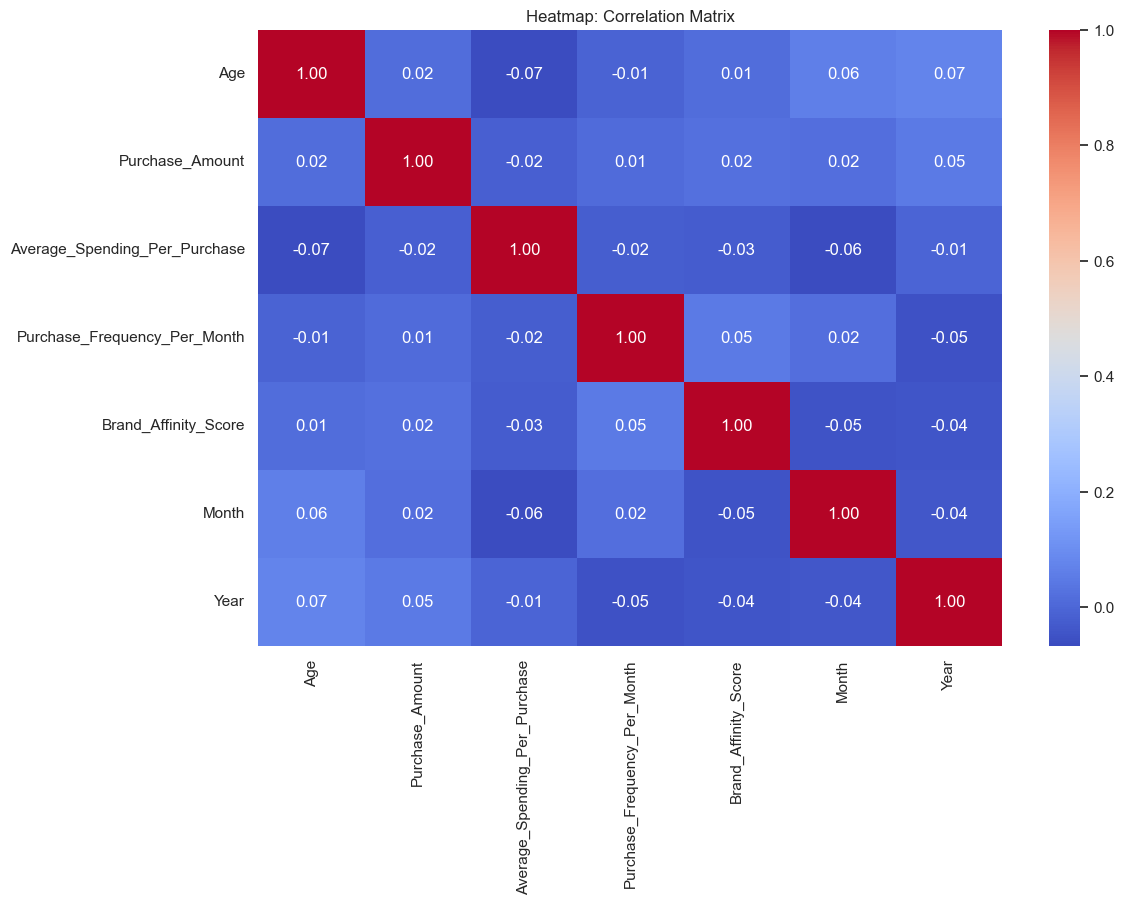

In [47]:
numeric_columns = file.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = file[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap: Correlation Matrix')
plt.show()

## 3. Temporal Analysis:

### **Trends in Purchase Per Month wrt Brands:**

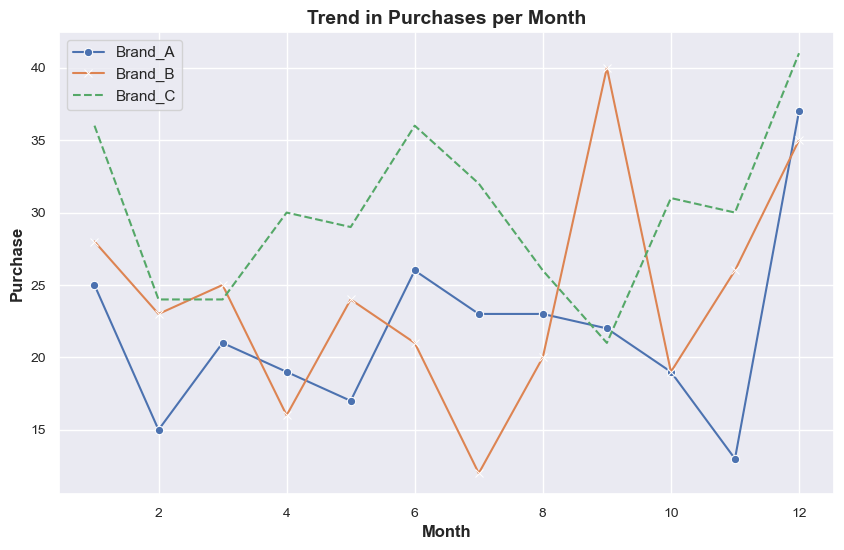

In [48]:
yearly_Purchase = file.groupby([file['Purchase_Date'].dt.month, 'Brand']).size()
yearly_Purchase = yearly_Purchase.unstack()
sns.set(rc={'figure.figsize':(10,6)})

sns.lineplot(data=yearly_Purchase, x=yearly_Purchase.index, y='Brand_A', label='Brand_A', marker='o')
sns.lineplot(data=yearly_Purchase, x=yearly_Purchase.index, y='Brand_B', label='Brand_B', marker='x')
sns.lineplot(data=yearly_Purchase, x=yearly_Purchase.index, y='Brand_C', label='Brand_C', linestyle='--')
plt.title('Trend in Purchases per Month', fontsize=14, fontweight="bold")
plt.xlabel('Month', fontsize=12, fontweight="bold")
plt.ylabel('Purchase', fontsize=12, fontweight="bold")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

### **Trends in Purchase Per Year wrt Brands:**

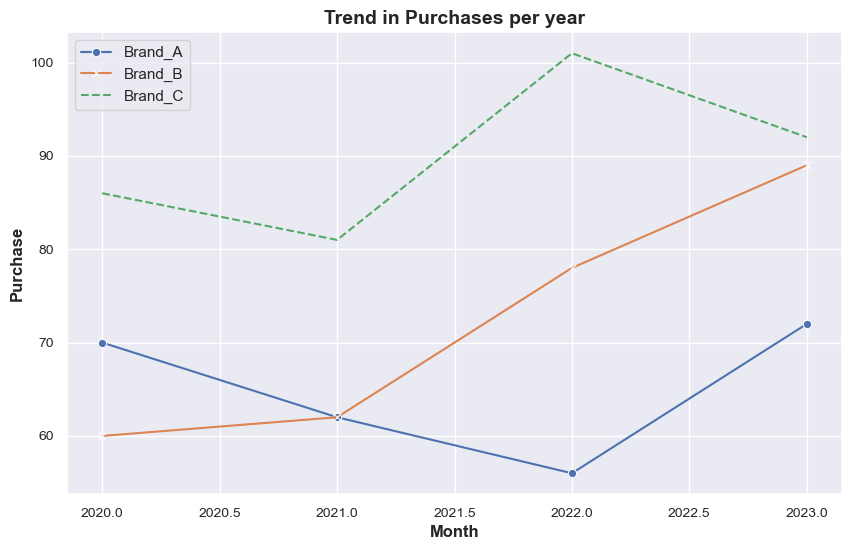

In [49]:
yearly_Purchase = file.groupby([file['Purchase_Date'].dt.year, 'Brand']).size()
yearly_Purchase = yearly_Purchase.unstack()
sns.set(rc={'figure.figsize':(10,6)})

sns.lineplot(data=yearly_Purchase, x=yearly_Purchase.index, y='Brand_A', label='Brand_A', marker='o')
sns.lineplot(data=yearly_Purchase, x=yearly_Purchase.index, y='Brand_B', label='Brand_B', marker='x')
sns.lineplot(data=yearly_Purchase, x=yearly_Purchase.index, y='Brand_C', label='Brand_C', linestyle='--')
plt.title('Trend in Purchases per year', fontsize=14, fontweight="bold")
plt.xlabel('Month', fontsize=12, fontweight="bold")
plt.ylabel('Purchase', fontsize=12, fontweight="bold")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

### **Purchase Frequency Overtime:**

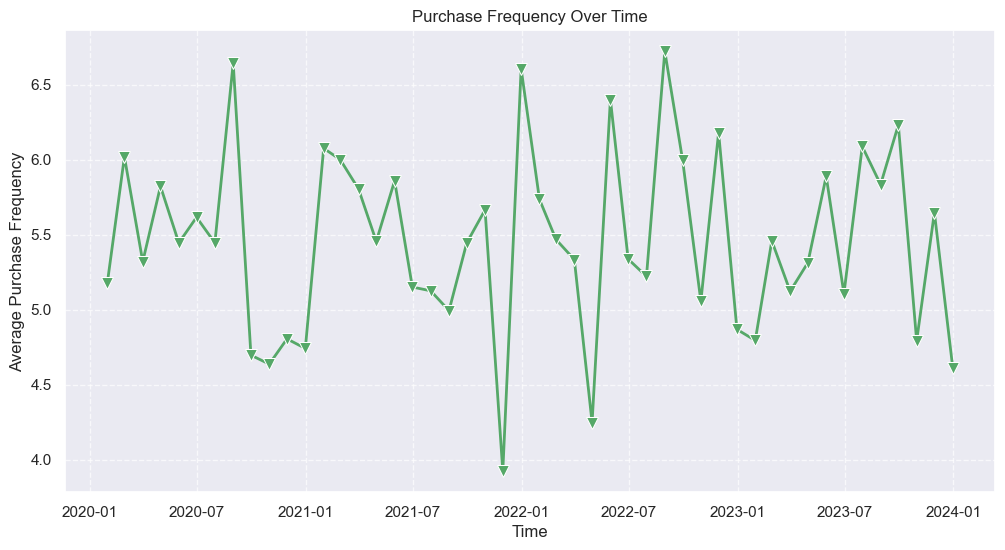

In [50]:
purchase_frequency_over_time = file.resample('M', on='Purchase_Date')['Purchase_Frequency_Per_Month'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=purchase_frequency_over_time.index, y=purchase_frequency_over_time.values, color='g', marker='v', linestyle='-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Purchase Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Average Purchase Frequency')
plt.show()

# 3. Clustering Analysis
Analyzing dataset on kmeans, DBscan, and kmeans++

## A: Kmeans Clustering:

### Applying Elbow Method to determine value of K

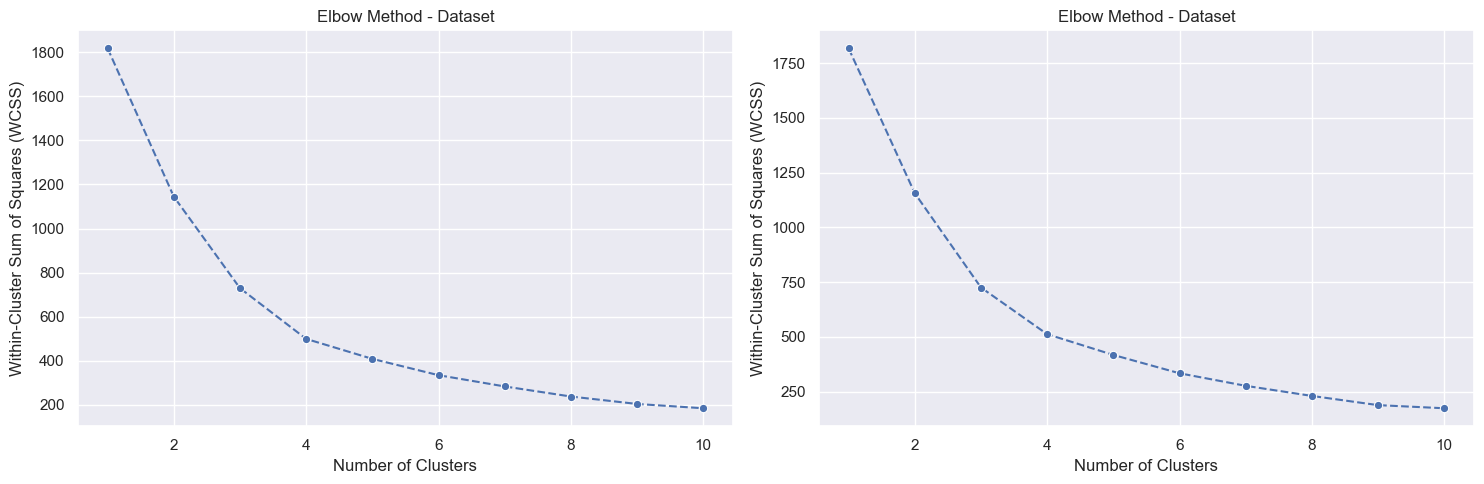

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=len(cluster_frames_standard), figsize=(15, 5))

for frame, ax in zip(cluster_frames_standard, axes):
    wcss = []
    range_clusters = range(1, 11)

    for k in range_clusters:
        warnings.filterwarnings("ignore")  # ignore warnings
        # Initialization set to random
        kmeans = KMeans(n_clusters=k, init="random", max_iter=300, n_init=10, random_state=0)

        # Fit KMeans on the scaled features (without modifying the original DataFrame)
        kmeans.fit(frame)

        # Append WCSS to the list
        wcss.append(kmeans.inertia_)

    # Plotting the elbow method for each dataset
    sns.lineplot(x=range_clusters, y=wcss, marker="o", linestyle="--", ax=ax)
    ax.set_title(f"Elbow Method - Dataset")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Within-Cluster Sum of Squares (WCSS)")


# Formatting subplot
plt.tight_layout()
plt.show()

### Applying Silhouette Analysis to determine value of K

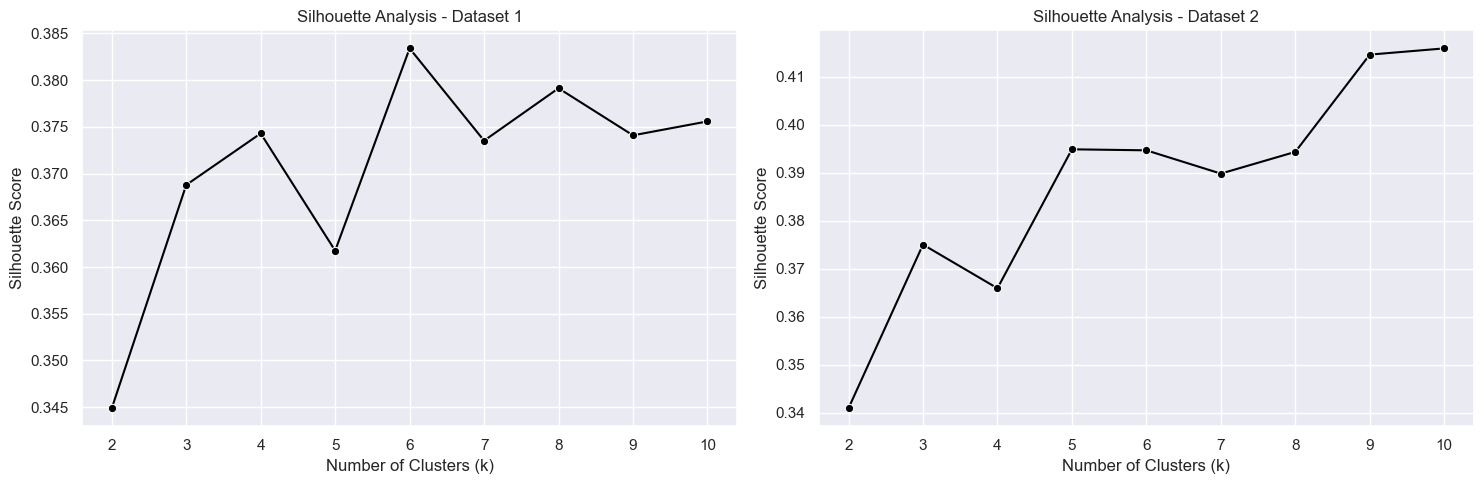

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=len(cluster_frames_standard), figsize=(15, 5))

for i, frame in enumerate(cluster_frames_standard):
    k_values = range(2, 11)
    silhouette_scores = []

    for k in k_values:
        warnings.filterwarnings("ignore") #ignore warnings
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(frame)
        silhouette_avg = silhouette_score(frame, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plotting silhouette scores for each dataset
    sns.lineplot(x=k_values, y=silhouette_scores, marker='o', color='black', ax=axes[i])
    axes[i].set_title(f'Silhouette Analysis - Dataset {i + 1}')
    axes[i].set_xlabel('Number of Clusters (k)')
    axes[i].set_ylabel('Silhouette Score')

# Formatting Subplot
plt.tight_layout()
plt.show()

### Applying K means on Cluster_frames

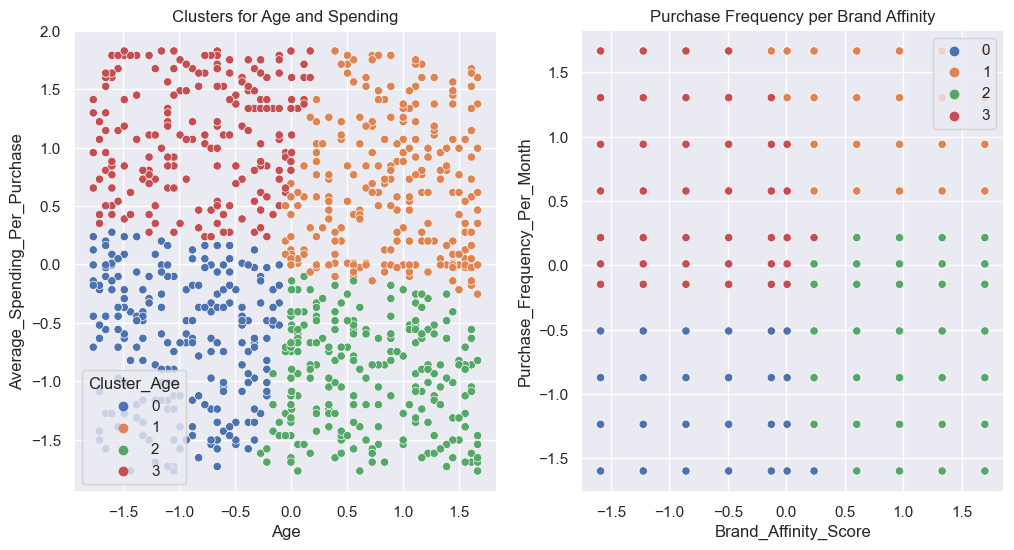

In [ ]:
k_clusters = 4

# Fit KMeans for average_purchase_per_age_standard
kmeans_age = KMeans(n_clusters=k_clusters, random_state=8)
average_purchase_per_age_standard['Cluster_Age'] = kmeans_age.fit_predict(average_purchase_per_age_standard)

# Fit KMeans for purchase frequency and brand affinity
kmeans_season = KMeans(n_clusters=k_clusters, random_state=6)
purchase_freq_affinity_standard['Cluster_Brand_Affinity_Score'] = kmeans_season.fit_predict(purchase_freq_affinity_standard[['Brand_Affinity_Score', 'Purchase_Frequency_Per_Month']])

# Plot scatter plots using seaborn
plt.figure(figsize=(12, 6))

# Scatter plot for average_purchase_per_age_standard
plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Average_Spending_Per_Purchase', hue='Cluster_Age', data=average_purchase_per_age_standard, palette='deep')
plt.title('Clusters for Age and Spending')

# Scatter plot for Average_Spending_Per_Season
plt.subplot(1, 2, 2)
sns.scatterplot(x='Brand_Affinity_Score', y='Purchase_Frequency_Per_Month', hue='Cluster_Brand_Affinity_Score', data=purchase_freq_affinity_standard, palette='deep')
plt.title('Purchase Frequency per Brand Affinity')
plt.legend(loc = "upper right")
plt.show()


### Applying DBScan on cluster frames

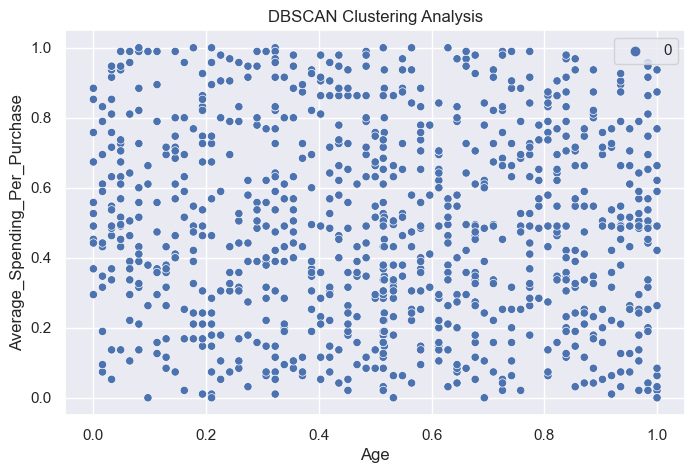

In [ ]:
# setting parameters
eps_value = 0.3 
min_samples_value = 2

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
average_purchase_per_age_normalized['Cluster_DBSCAN'] = dbscan.fit_predict(average_purchase_per_age_normalized[["Age", "Average_Spending_Per_Purchase"]])

# plotting
plt.figure(figsize=(8, 5))

# Scatter plot for Age and Average Spending with DBSCAN clusters
sns.scatterplot(x='Age', y='Average_Spending_Per_Purchase', hue='Cluster_DBSCAN', data=average_purchase_per_age_normalized, palette='deep')
plt.title('DBSCAN Clustering Analysis')
plt.legend(loc = "upper right")
plt.show()

### Applying Kmeans++

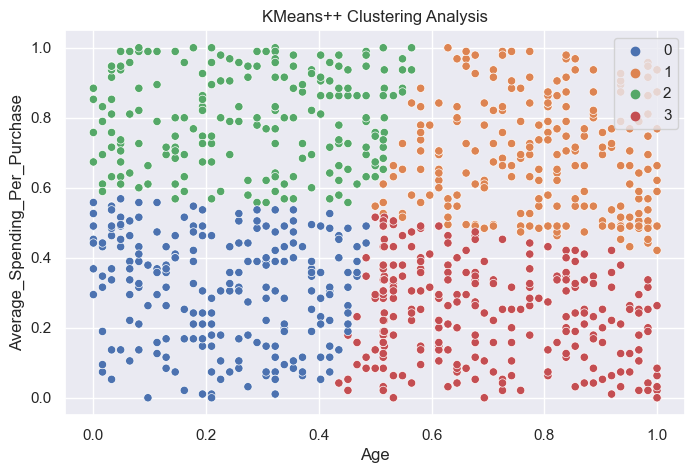

In [ ]:
k_clusters = 4  
kmeans = KMeans(n_clusters=k_clusters, random_state=42)  

# Fit KMeans to the data
average_purchase_per_age_normalized['Cluster_KMeans'] = kmeans.fit_predict(average_purchase_per_age_normalized[["Age", "Average_Spending_Per_Purchase"]])

# plotting
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='Average_Spending_Per_Purchase', hue='Cluster_KMeans', data=average_purchase_per_age_normalized, palette='deep')
plt.title('KMeans++ Clustering Analysis')
plt.legend(loc = "upper right")
plt.show()

# 4. Comparison and Conclusion

## 1. Results of Clustering Analysis

### **Analyze the similarity and differences in the clusters formed by K-Means, DBSCAN, and K-Means++.**

Kmeans and Kmeans++ are generating similar results and DBscan was unable to identify trend and therefore form clusters in the data it was tested upon. Although dbscan fails to identify clusters, Kmeans and Kmeans++ identified 4 clusters from the input data and show extremely similar trends.

### **Evaluate the effectiveness of each algorithm in identifying distinct customer segments based on their purchase behavior and preferences.**

Both Kmeans and Kmeans++ provide good inisght to the trends within the dataset. Visually, both show similar clusters and either clustering echnque can be opted, In this scenario We'll opt for kmeans++ for its simplicity and better working over Kmeans.

### **Consider metrics such as cluster silhouette score, Calinski-Harabasz score, and Davies-Bouldin index to compare the overall quality of clustering results.**

Based upon the cluster silhouette plot and kmeans and kmeans++ plot, the silhouette was accuretly able to depict the quality of clusters being formed with in the dataset

### **Discuss the advantages and disadvantages of each algorithm in the context of Imtiaz Mall's specific needs and data characteristics.**

| **KMeans**                                | **KMeans++**                              | **DBSCAN**                               |
|-------------------------------------------|-------------------------------------------|------------------------------------------|
| Was easy to implement                     | Was easy to implement similar to KMeans | Was hard to implement due to parameters  |
| Clusters were overlapping in some cases   | Had some overlap between clusters        | Was unable to form clusters              |
| Was unstable and formed poor initial clusters | Formed better initial clusters as compared to KMeans | Poor performance due to errors in selecting parameters |


## 2. Conclusions and Reccomendations

### Based on the findings of the EDA and clustering analysis, provide insights into the customer segments within the electronics section.

Upon EDA analysis, it can be safely deduced that Electronics department was the most popular deparment of Imtiaz Store

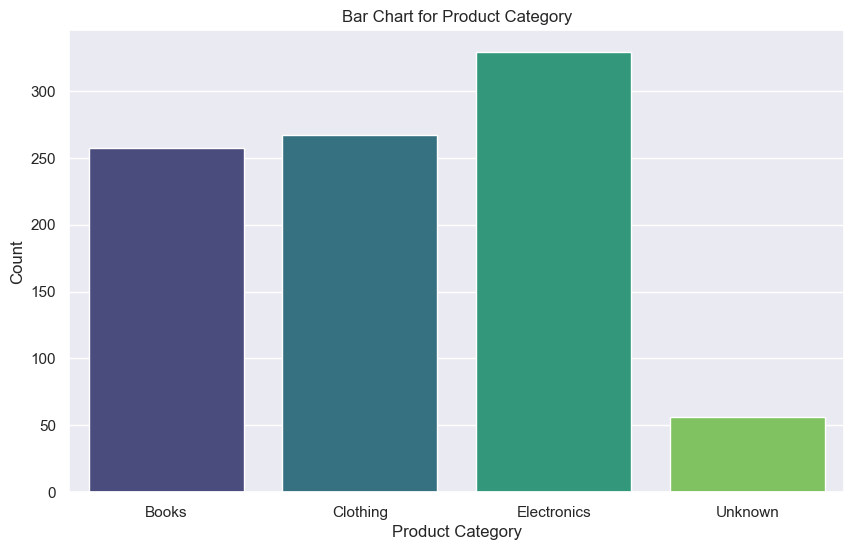

In [53]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Product_Category', data=file, palette='viridis')
plt.title('Bar Chart for Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()

### Identify the key factors that differentiate the customer segments and explain their purchasing behavior patterns.

•	The key factors that differentiate customer segments include age, income level, brand affinity, and product category preferences. 

•	These factors contribute to the unique purchasing behavior patterns observed in each segment.

•	By analyzing customer data, we found distinct groups that shop differently and have diverse preferences for brands and products.

•	By knowing what they like and when they buy, we can create special offers that match their interests and increase their loyalty.

•	Different groups of customers buy things in different ways. For example, one group might really like fancy electronics and spend more money on average, while another group might care more about prices and go for budget-friendly options.


### Propose further analysis and investigations to enhance the understanding of customer behavior and optimize the performance of the electronics section.

Customer behaviour can be further analyzed by increaring the width of dataset 